### Install and import necessary libraries



In [1]:
!pip install snntorch
!pip install tonic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 5.0 MB/s eta 0:00:00


In [4]:
import torch
import snntorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_per_process_memory_fraction(0.85, device=0)



import numpy as np

import tonic
from tonic import datasets, transforms
import torchvision as tv
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from collections import namedtuple

State = namedtuple("State", "obs labels")



### SHD2Raster: Tool for Rasterizing SHD (Spiking Neural Network) Samples into Frames

In [5]:
class _SHD2Raster():
    """
    Tool for rastering SHD samples into frames.
    This class is used to convert event-based data into a frame format suitable for use in neural networks.
    It packs bits along the temporal axis for memory efficiency, meaning the user will need to apply
    `jnp.unpackbits(events, axis=<time axis>)` prior to feeding the data into the network.
    """

    def __init__(self, encoding_dim, sample_T = 100):
        """
        Initializes the rasterizer with the desired encoding dimension and the sample duration.

        Args:
            encoding_dim (int): The number of possible spatial locations in the raster (i.e., width of the frame).
            sample_T (int, optional): The number of time steps to consider from the event stream. Defaults to 100.
        """
        self.encoding_dim = encoding_dim  # Set the encoding dimension (width of the frame)
        self.sample_T = sample_T  # Set the number of time steps to sample

    def __call__(self, events):
        """
        Converts event-based data into a rasterized tensor format for neural network input.

        Args:
            events (dict): A dictionary containing event-based data, which should include:
                - "t": Array of time steps for each event
                - "x": Array of spatial indices for each event

        Returns:
            numpy.ndarray: A binary tensor representing the rasterized events, shaped as [time_steps, encoding_dim].
        """

        # Initialize a zero matrix with shape (max_time_step+1, encoding_dim), to hold the event counts
        tensor = np.zeros((events["t"].max() + 1, self.encoding_dim), dtype=int)

        # Increment the corresponding positions in the tensor where events occurred (based on time 't' and spatial location 'x')
        np.add.at(tensor, (events["t"], events["x"]), 1)

        # Only keep the first 'sample_T' time steps
        tensor = tensor[:self.sample_T, :]

        # Set all values greater than 1 to 1, ensuring it's a binary representation
        tensor = np.minimum(tensor, 1)

        # Return the rasterized tensor
        return tensor


### Dowloading and Transforming SHD Dataset

In [6]:
# Define constants and parameters for processing
sample_T = 64                 # Number of timesteps to sample for the rasterized input
shd_timestep = 1e-6           # Time resolution of the SHD dataset in seconds (1 microsecond)
shd_channels = 700            # Number of spatial channels in the SHD dataset
net_channels = 128            # Number of spatial channels in the network
net_dt = 1 / sample_T         # Time step for the network (inverse of sample_T)
batch_size = 256              # Batch size for training and testing

# Define observation and action shapes for the network
obs_shape = tuple([net_channels,])  # Shape of the network's input (net_channels spatial dimension)
act_shape = tuple([20,])            # Shape of the network's output (e.g., 20 classes)

# Define transformations for the dataset
transform = transforms.Compose([
    # Downsample the data temporally and spatially to match the network's dimensions
    transforms.Downsample(
        time_factor=shd_timestep / net_dt,        # Factor to reduce the temporal resolution
        spatial_factor=net_channels / shd_channels  # Factor to reduce the spatial resolution
    ),
    # Convert SHD spike trains to rasterized input suitable for the network
    _SHD2Raster(net_channels, sample_T=sample_T)
])

# Load the SHD (Spiking Heidelberg Dataset) for training
train_dataset = datasets.SHD(
    "./data",              # Path to the dataset
    train=True,            # Load the training split
    transform=transform    # Apply the defined transformations
)

# Load the SHD dataset for testing
test_dataset = datasets.SHD(
    "./data",              # Path to the dataset
    train=False,           # Load the testing split
    transform=transform    # Apply the defined transformations
)

  0%|          | 0/130863613 [00:00<?, ?it/s]

Extracting ./data/SHD/shd_train.h5.zip to ./data/SHD


  0%|          | 0/38141465 [00:00<?, ?it/s]

Extracting ./data/SHD/shd_test.h5.zip to ./data/SHD


### Preparing DataLoader for Training and Testing Datasets with Padded Tensors along with shuffle function for converting data into batches of 256

In [7]:
# Create a DataLoader to iterate through the training dataset
train_dl = iter(DataLoader(
    train_dataset,                                  # The SHD training dataset
    batch_size=len(train_dataset),                 # Set batch size to the full dataset size
    collate_fn=tonic.collation.PadTensors(         # Collate function to pad tensors for uniform dimensions
        batch_first=True                           # Ensure the batch dimension comes first
    ),
    drop_last=True,                                # Drop the last incomplete batch if dataset size is not divisible
    shuffle=False                                  # Do not shuffle the dataset
))

# Extract the first (and only) batch of data from the DataLoader
x_train, y_train = next(train_dl)                 # `x_train` contains input data, `y_train` contains labels

# Convert the data and labels to 8-bit unsigned integer tensors
x_train, y_train = x_train.to(torch.uint8), y_train.to(torch.uint8)

# Move the data and labels to the specified device (CPU or GPU)
x_train, y_train = x_train.to(device), y_train.to(device)


In [8]:
def shuffle(dataset):
    x, y = dataset

    cutoff = y.shape[0] % batch_size

    indices = torch.randperm(y.shape[0])[:-cutoff]
    obs, labels = x[indices], y[indices]


    obs = torch.reshape(obs, (-1, batch_size) + obs.shape[1:])
    labels = torch.reshape(labels, (-1, batch_size)) # should make batch size a global

    return State(obs=obs, labels=labels)

In [9]:
test_dl = iter(DataLoader(test_dataset, batch_size=len(test_dataset),
                          collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False))

x_test, y_test = next(test_dl)
x_test, y_test = x_test.to(torch.uint8), y_test.to(torch.uint8)
x_test, y_test = x_test.to(device), y_test.to(device)
x_test, y_test = shuffle((x_test, y_test))

In [10]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([8156, 64, 128])
torch.Size([8, 256, 64, 128])
torch.Size([8156])
torch.Size([8, 256])


### Basic SNN Network with 2 Hidden Layers

In [11]:
num_hidden = 64  # Number of hidden units in the network

# Define the Network class, inheriting from PyTorch's nn.Module
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers in the network
        self.fc1 = torch.nn.Linear(128, num_hidden)  # Fully connected layer (input size 128, hidden size 'num_hidden')

        # Leaky Integrate-and-Fire (LIF) neuron model for the first hidden layer
        self.lif1 = snntorch.Leaky(beta=torch.ones(num_hidden)*0.5, learn_beta=True)  # Initialize LIF with beta as 0.5 (with learnable beta)

        self.fc2 = torch.nn.Linear(num_hidden, num_hidden)  # Fully connected layer (hidden size 'num_hidden' to 'num_hidden')

        # Leaky Integrate-and-Fire (LIF) neuron model for the second hidden layer
        self.lif2 = snntorch.Leaky(beta=torch.ones(num_hidden)*0.5, learn_beta=True)  # Same initialization for second LIF layer

        self.fc3 = torch.nn.Linear(num_hidden, 20)  # Fully connected layer (hidden size 'num_hidden' to output size 20)

        # Leaky Integrate-and-Fire (LIF) neuron model for the output layer
        self.lif3 = snntorch.Leaky(beta=torch.ones(20)*0.5, learn_beta=True, reset_mechanism="none")  # No reset for the output LIF layer

    def forward(self, x):
        """
        Forward pass through the network.
        Args:
            x (Tensor): Input tensor with shape [batch, time, channel]
        Returns:
            Tensor: Output tensor after passing through the network
        """

        x = x.float()  # Ensure the input is in float format (necessary for SNNs)

        # Permute the input to have time as the leading axis
        x = x.permute(1,0,2)  # [time, batch, channel]

        # Initialize hidden states for all LIF layers (at t=0)
        mem1 = self.lif1.init_leaky()  # Memory for the first layer
        mem2 = self.lif2.init_leaky()  # Memory for the second layer
        mem3 = self.lif3.init_leaky()  # Memory for the third layer (output layer)

        V = []  # To store the membrane potential of the output layer over time

        # Loop through the time steps (temporal dimension) of the input
        for i, step in enumerate(x):
            # Compute the current value from the first layer
            cur1 = self.fc1(step)
            # Apply the LIF neuron model (spike and update memory)
            spk1, mem1 = self.lif1(cur1, mem1)

            # Compute the current value for the second layer
            cur2 = self.fc2(spk1)
            # Apply the LIF neuron model for the second layer
            spk2, mem2 = self.lif2(cur2, mem2)

            # Compute the current value for the third layer (output layer)
            cur3 = self.fc3(spk2)
            # Apply the LIF neuron model for the third layer
            spk3, mem3 = self.lif3(cur3, mem3)

            # Store the membrane potential of the output layer for each time step
            V.append(mem3)

        # Stack the membrane potentials across all time steps and permute the dimensions back to [batch, time, channel]
        return torch.stack(V, axis=0).permute(1,0,2)

# Load the network onto CUDA if available
net = Net().to(device)  # Move the model to the GPU or CPU based on device availability

### Total Parameters

In [12]:
total_params = sum(p.numel() for p in net.parameters())

print(f"Total Parameters in the Network: {total_params}")

Total Parameters in the Network: 13864


### Loss, Optimizer and Accuracy

In [19]:
# Cross Entropy Loss with label smoothing
loss = torch.nn.CrossEntropyLoss(label_smoothing=0.3)

# Optimizer: Adam optimizer for training the model
# This optimizer is adaptive, adjusting learning rates based on past gradients.
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

# Accuracy calculation function
# This lambda function computes the accuracy by comparing the predicted class
acc = lambda predictions, targets : (torch.argmax(predictions, axis=-1) == targets).sum().item() / len(targets)

### Training and Testing Loop with Graphs

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Training Loss = 3.4053, Training Accuracy = 9.14%


Training Epochs:   2%|▏         | 1/50 [00:07<05:49,  7.14s/it]

Epoch 1: Test Loss = 3.2841, Test Accuracy = 15.82%
Epoch 2: Training Loss = 3.1761, Training Accuracy = 15.12%


Training Epochs:   4%|▍         | 2/50 [00:13<05:22,  6.72s/it]

Epoch 2: Test Loss = 3.1077, Test Accuracy = 20.61%
Epoch 3: Training Loss = 3.0510, Training Accuracy = 18.56%


Training Epochs:   6%|▌         | 3/50 [00:20<05:20,  6.82s/it]

Epoch 3: Test Loss = 2.9717, Test Accuracy = 25.88%
Epoch 4: Training Loss = 2.9510, Training Accuracy = 22.58%


Training Epochs:   8%|▊         | 4/50 [00:26<05:06,  6.65s/it]

Epoch 4: Test Loss = 2.8742, Test Accuracy = 27.83%
Epoch 5: Training Loss = 2.8715, Training Accuracy = 25.19%


Training Epochs:  10%|█         | 5/50 [00:34<05:13,  6.97s/it]

Epoch 5: Test Loss = 2.8088, Test Accuracy = 30.86%
Epoch 6: Training Loss = 2.7959, Training Accuracy = 28.14%


Training Epochs:  12%|█▏        | 6/50 [00:40<04:54,  6.69s/it]

Epoch 6: Test Loss = 2.7184, Test Accuracy = 33.69%
Epoch 7: Training Loss = 2.7277, Training Accuracy = 31.02%


Training Epochs:  14%|█▍        | 7/50 [00:47<04:51,  6.79s/it]

Epoch 7: Test Loss = 2.6648, Test Accuracy = 34.96%
Epoch 8: Training Loss = 2.6689, Training Accuracy = 32.67%


Training Epochs:  16%|█▌        | 8/50 [00:53<04:38,  6.62s/it]

Epoch 8: Test Loss = 2.5878, Test Accuracy = 37.79%
Epoch 9: Training Loss = 2.6134, Training Accuracy = 35.18%


Training Epochs:  18%|█▊        | 9/50 [01:00<04:35,  6.73s/it]

Epoch 9: Test Loss = 2.5336, Test Accuracy = 39.94%
Epoch 10: Training Loss = 2.5653, Training Accuracy = 37.45%


Training Epochs:  20%|██        | 10/50 [01:07<04:24,  6.61s/it]

Epoch 10: Test Loss = 2.5066, Test Accuracy = 41.36%
Epoch 11: Training Loss = 2.5246, Training Accuracy = 39.91%


Training Epochs:  22%|██▏       | 11/50 [01:14<04:21,  6.71s/it]

Epoch 11: Test Loss = 2.4689, Test Accuracy = 43.51%
Epoch 12: Training Loss = 2.4837, Training Accuracy = 42.62%


Training Epochs:  24%|██▍       | 12/50 [01:20<04:13,  6.68s/it]

Epoch 12: Test Loss = 2.4497, Test Accuracy = 43.80%
Epoch 13: Training Loss = 2.4592, Training Accuracy = 44.03%


Training Epochs:  26%|██▌       | 13/50 [01:27<04:06,  6.66s/it]

Epoch 13: Test Loss = 2.4096, Test Accuracy = 47.71%
Epoch 14: Training Loss = 2.4317, Training Accuracy = 45.24%


Training Epochs:  28%|██▊       | 14/50 [01:34<04:03,  6.77s/it]

Epoch 14: Test Loss = 2.4104, Test Accuracy = 47.61%
Epoch 15: Training Loss = 2.4070, Training Accuracy = 47.64%


Training Epochs:  30%|███       | 15/50 [01:40<03:51,  6.62s/it]

Epoch 15: Test Loss = 2.4011, Test Accuracy = 47.85%
Epoch 16: Training Loss = 2.3851, Training Accuracy = 49.58%


Training Epochs:  32%|███▏      | 16/50 [01:47<03:48,  6.73s/it]

Epoch 16: Test Loss = 2.4168, Test Accuracy = 48.39%
Epoch 17: Training Loss = 2.3582, Training Accuracy = 51.70%


Training Epochs:  34%|███▍      | 17/50 [01:53<03:37,  6.58s/it]

Epoch 17: Test Loss = 2.4044, Test Accuracy = 48.05%
Epoch 18: Training Loss = 2.3513, Training Accuracy = 51.61%


Training Epochs:  36%|███▌      | 18/50 [02:00<03:33,  6.68s/it]

Epoch 18: Test Loss = 2.3821, Test Accuracy = 50.98%
Epoch 19: Training Loss = 2.3359, Training Accuracy = 52.89%


Training Epochs:  38%|███▊      | 19/50 [02:07<03:25,  6.61s/it]

Epoch 19: Test Loss = 2.3873, Test Accuracy = 49.90%
Epoch 20: Training Loss = 2.3073, Training Accuracy = 55.02%


Training Epochs:  40%|████      | 20/50 [02:14<03:22,  6.74s/it]

Epoch 20: Test Loss = 2.3904, Test Accuracy = 50.39%
Epoch 21: Training Loss = 2.3006, Training Accuracy = 55.73%


Training Epochs:  42%|████▏     | 21/50 [02:20<03:10,  6.58s/it]

Epoch 21: Test Loss = 2.3900, Test Accuracy = 50.59%
Epoch 22: Training Loss = 2.2932, Training Accuracy = 56.16%


Training Epochs:  44%|████▍     | 22/50 [02:27<03:07,  6.71s/it]

Epoch 22: Test Loss = 2.3768, Test Accuracy = 52.29%
Epoch 23: Training Loss = 2.2869, Training Accuracy = 57.38%


Training Epochs:  46%|████▌     | 23/50 [02:33<02:57,  6.58s/it]

Epoch 23: Test Loss = 2.3596, Test Accuracy = 52.73%
Epoch 24: Training Loss = 2.2819, Training Accuracy = 56.74%


Training Epochs:  48%|████▊     | 24/50 [02:40<02:53,  6.68s/it]

Epoch 24: Test Loss = 2.3757, Test Accuracy = 50.39%
Epoch 25: Training Loss = 2.2653, Training Accuracy = 58.27%


Training Epochs:  50%|█████     | 25/50 [02:47<02:45,  6.62s/it]

Epoch 25: Test Loss = 2.3614, Test Accuracy = 52.15%
Epoch 26: Training Loss = 2.2553, Training Accuracy = 59.48%


Training Epochs:  52%|█████▏    | 26/50 [02:53<02:39,  6.63s/it]

Epoch 26: Test Loss = 2.3657, Test Accuracy = 51.66%
Epoch 27: Training Loss = 2.2389, Training Accuracy = 60.45%


Training Epochs:  54%|█████▍    | 27/50 [03:00<02:33,  6.69s/it]

Epoch 27: Test Loss = 2.3379, Test Accuracy = 54.10%
Epoch 28: Training Loss = 2.2370, Training Accuracy = 60.48%


Training Epochs:  56%|█████▌    | 28/50 [03:07<02:25,  6.61s/it]

Epoch 28: Test Loss = 2.3605, Test Accuracy = 53.12%
Epoch 29: Training Loss = 2.2305, Training Accuracy = 61.37%


Training Epochs:  58%|█████▊    | 29/50 [03:14<02:21,  6.72s/it]

Epoch 29: Test Loss = 2.3561, Test Accuracy = 53.08%
Epoch 30: Training Loss = 2.2273, Training Accuracy = 61.05%


Training Epochs:  60%|██████    | 30/50 [03:20<02:11,  6.58s/it]

Epoch 30: Test Loss = 2.3927, Test Accuracy = 49.90%
Epoch 31: Training Loss = 2.2237, Training Accuracy = 61.39%


Training Epochs:  62%|██████▏   | 31/50 [03:27<02:07,  6.70s/it]

Epoch 31: Test Loss = 2.3928, Test Accuracy = 51.76%
Epoch 32: Training Loss = 2.2254, Training Accuracy = 61.49%


Training Epochs:  64%|██████▍   | 32/50 [03:33<01:58,  6.57s/it]

Epoch 32: Test Loss = 2.3430, Test Accuracy = 52.78%
Epoch 33: Training Loss = 2.2168, Training Accuracy = 62.22%


Training Epochs:  66%|██████▌   | 33/50 [03:40<01:53,  6.68s/it]

Epoch 33: Test Loss = 2.3585, Test Accuracy = 52.05%
Epoch 34: Training Loss = 2.2079, Training Accuracy = 62.83%


Training Epochs:  68%|██████▊   | 34/50 [03:46<01:44,  6.54s/it]

Epoch 34: Test Loss = 2.3693, Test Accuracy = 51.27%
Epoch 35: Training Loss = 2.2045, Training Accuracy = 62.78%


Training Epochs:  70%|███████   | 35/50 [03:53<01:39,  6.66s/it]

Epoch 35: Test Loss = 2.3145, Test Accuracy = 55.66%
Epoch 36: Training Loss = 2.2008, Training Accuracy = 63.67%


Training Epochs:  72%|███████▏  | 36/50 [03:59<01:31,  6.53s/it]

Epoch 36: Test Loss = 2.3510, Test Accuracy = 54.05%
Epoch 37: Training Loss = 2.1915, Training Accuracy = 64.10%


Training Epochs:  74%|███████▍  | 37/50 [04:06<01:26,  6.67s/it]

Epoch 37: Test Loss = 2.3299, Test Accuracy = 54.25%
Epoch 38: Training Loss = 2.1893, Training Accuracy = 64.44%


Training Epochs:  76%|███████▌  | 38/50 [04:13<01:18,  6.57s/it]

Epoch 38: Test Loss = 2.3211, Test Accuracy = 54.79%
Epoch 39: Training Loss = 2.1770, Training Accuracy = 65.46%


Training Epochs:  78%|███████▊  | 39/50 [04:20<01:13,  6.67s/it]

Epoch 39: Test Loss = 2.3028, Test Accuracy = 58.01%
Epoch 40: Training Loss = 2.1665, Training Accuracy = 65.97%


Training Epochs:  80%|████████  | 40/50 [04:26<01:06,  6.67s/it]

Epoch 40: Test Loss = 2.3252, Test Accuracy = 55.47%
Epoch 41: Training Loss = 2.1637, Training Accuracy = 66.54%


Training Epochs:  82%|████████▏ | 41/50 [04:33<01:00,  6.67s/it]

Epoch 41: Test Loss = 2.3282, Test Accuracy = 54.20%
Epoch 42: Training Loss = 2.1553, Training Accuracy = 67.54%


Training Epochs:  84%|████████▍ | 42/50 [04:40<00:54,  6.76s/it]

Epoch 42: Test Loss = 2.3128, Test Accuracy = 56.88%
Epoch 43: Training Loss = 2.1416, Training Accuracy = 68.13%


Training Epochs:  86%|████████▌ | 43/50 [04:46<00:46,  6.60s/it]

Epoch 43: Test Loss = 2.2765, Test Accuracy = 59.13%
Epoch 44: Training Loss = 2.1373, Training Accuracy = 68.51%


Training Epochs:  88%|████████▊ | 44/50 [04:53<00:40,  6.72s/it]

Epoch 44: Test Loss = 2.3165, Test Accuracy = 56.49%
Epoch 45: Training Loss = 2.1370, Training Accuracy = 68.46%


Training Epochs:  90%|█████████ | 45/50 [04:59<00:32,  6.58s/it]

Epoch 45: Test Loss = 2.2908, Test Accuracy = 57.81%
Epoch 46: Training Loss = 2.1269, Training Accuracy = 69.17%


Training Epochs:  92%|█████████▏| 46/50 [05:06<00:26,  6.72s/it]

Epoch 46: Test Loss = 2.3238, Test Accuracy = 56.54%
Epoch 47: Training Loss = 2.1259, Training Accuracy = 69.13%


Training Epochs:  94%|█████████▍| 47/50 [05:13<00:19,  6.58s/it]

Epoch 47: Test Loss = 2.2917, Test Accuracy = 59.38%
Epoch 48: Training Loss = 2.1135, Training Accuracy = 70.19%


Training Epochs:  96%|█████████▌| 48/50 [05:20<00:13,  6.72s/it]

Epoch 48: Test Loss = 2.2612, Test Accuracy = 61.08%
Epoch 49: Training Loss = 2.1102, Training Accuracy = 70.73%


Training Epochs:  98%|█████████▊| 49/50 [05:26<00:06,  6.59s/it]

Epoch 49: Test Loss = 2.2486, Test Accuracy = 61.62%
Epoch 50: Training Loss = 2.1038, Training Accuracy = 70.94%


Training Epochs: 100%|██████████| 50/50 [05:33<00:00,  6.67s/it]

Epoch 50: Test Loss = 2.2629, Test Accuracy = 60.21%


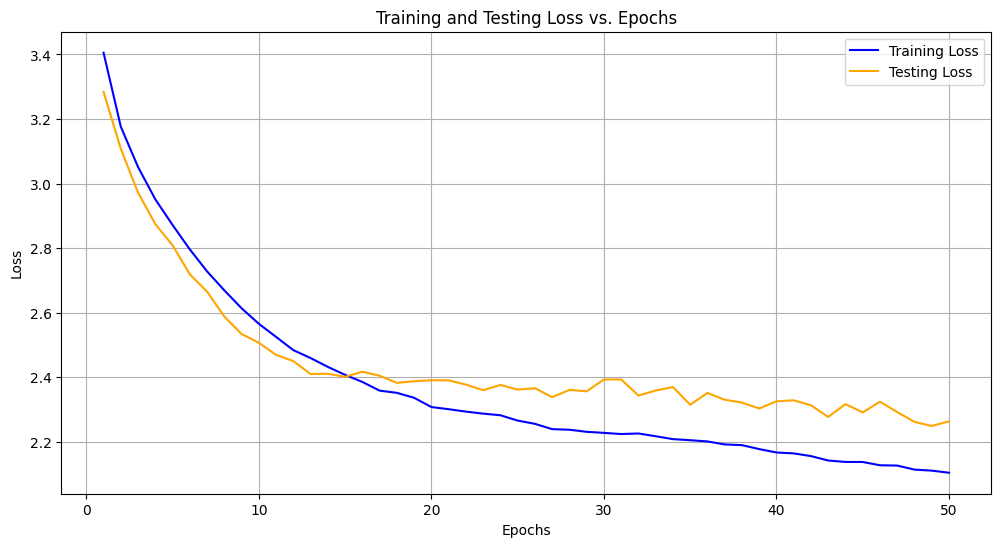

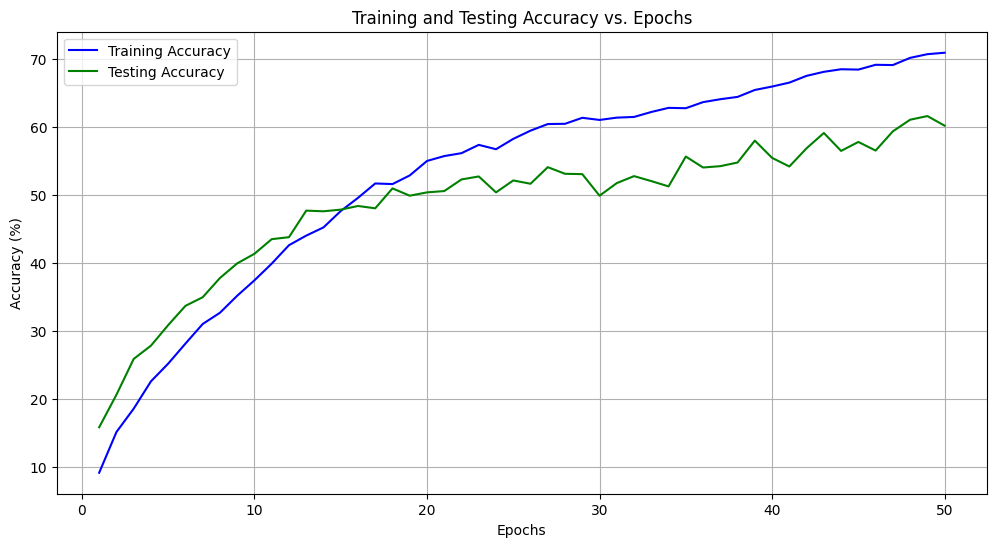

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

num_epochs = 50  # Example number of epochs
loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Outer training loop
for epoch in tqdm.tqdm(range(num_epochs), desc="Training Epochs"):
    # Shuffle and prepare training batch
    train_batch = shuffle((x_train, y_train))
    train_data, train_targets = train_batch

    epoch_loss = 0  # To track average loss for the epoch
    batch_train_acc = []  # To track accuracy for the training set in this epoch

    # Minibatch training loop
    for data, targets in zip(train_data, train_targets):
        # Forward pass
        net.train()
        out_V = net(data)
        # Initialize the loss & sum over time
        loss_val = loss(torch.sum(out_V, axis=-2), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss_val.item()

        # Calculate training accuracy
        batch_train_acc.append(acc(torch.sum(out_V, axis=-2), targets))

    # Compute average loss and accuracy for the epoch
    avg_epoch_loss = epoch_loss / len(train_data)
    avg_train_acc = np.mean(batch_train_acc) * 100  # Convert accuracy to percentage

    loss_hist.append(avg_epoch_loss)
    train_acc_hist.append(avg_train_acc)

    print(f"Epoch {epoch+1}: Training Loss = {avg_epoch_loss:.4f}, Training Accuracy = {avg_train_acc:.2f}%")

    # Test set evaluation at the end of each epoch
    with torch.no_grad():
        batch_test_acc = []
        batch_test_loss = []

        for test_data, test_targets in zip(x_test, y_test):
            net.eval()
            # Test set forward pass
            out_V = net(test_data)
            # Calculate accuracy and loss
            batch_test_acc.append(acc(torch.sum(out_V, axis=-2), test_targets))
            test_loss = loss(torch.sum(out_V, axis=-2), test_targets).item()
            batch_test_loss.append(test_loss)

        # Average test accuracy and test loss for the epoch
        avg_test_acc = np.mean(batch_test_acc) * 100  # Convert accuracy to percentage
        avg_test_loss = np.mean(batch_test_loss)

        test_loss_hist.append(avg_test_loss)
        test_acc_hist.append(avg_test_acc)

        print(f"Epoch {epoch+1}: Test Loss = {avg_test_loss:.4f}, Test Accuracy = {avg_test_acc:.2f}%")

# Plotting graphs
epochs = np.arange(1, num_epochs + 1)

# Plot Training and Testing Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_hist, label="Training Loss", color="blue")
plt.plot(epochs, test_loss_hist, label="Testing Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Testing Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_hist, label="Training Accuracy", color="blue")
plt.plot(epochs, test_acc_hist, label="Testing Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()
